## Import essential packages

In [1]:
#----- These are for the simulation 

from __future__ import division
import hoomd
import hoomd.md
import numpy
from matplotlib import pyplot

#----- These are for the orientation analysis

import gsd
import gsd.hoomd

# Simulation

In [2]:
#-----Some important variables

box = 12.5
replicates = 10
p_max = 0.5
t_max = 2.2

In [3]:
#-------Define the unit cell

sim = hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [box, 0, 0],
                            a2 = [0, box, 0],
                            a3 = [0, 0, box],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['M'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);

#-----From the lattice we obtain a snapshot and initialize.

snapshot = uc.get_snapshot()
snapshot.replicate(replicates,replicates,replicates)
system = hoomd.init.read_snapshot(snapshot)

#-----Add the particle type for the constituent particles.

system.particles.types.add('A');

#-----Define each rigid body type in the local coordinate system of the body.

rigid = hoomd.md.constrain.rigid();
rigid.set_param('M', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

#-----Instruct the rigid constraint to create the constituent particles

rigid.create_bodies();

#-----Define the potential energy

nl = hoomd.md.nlist.cell()

lj = hoomd.md.pair.lj(r_cut = 3.5, nlist=nl)
lj.set_params(mode='shift')

#-----Define interaction with species in the binary mixture

lj.pair_coeff.set('M','M', epsilon = 1.0, sigma = 1.0)
lj.pair_coeff.set('A','A', epsilon = 1.0, sigma = 1.0)
lj.pair_coeff.set('M','A', epsilon = 1.0, sigma = 1.0)


#-----Select an standard integrator

hoomd.md.integrate.mode_standard(dt=0.005);

#------Define group

mesogens = hoomd.group.rigid_center();

#----Integrate using NPT

pressure = hoomd.variant.linear_interp(points = [(0,1e-6), (2e4, p_max)])
npt = hoomd.md.integrate.npt(group = mesogens, kT = t_max, tau = 0.5, tauP = 1.0, P = pressure);
npt.randomize_velocities(seed=42)


#-----Write output



gsd_file = "trayectory_T_" + str(t_max) + "_P_" + str(p_max) + ".gsd"
hoomd.dump.gsd(gsd_file,
               period=1e3,
               group=hoomd.group.all(),
               overwrite=True);  


log_file = "trayectory_T_" + str(t_max) + "_P_" + str(p_max) + ".log"

log = hoomd.analyze.log(filename = log_file,
                         quantities = ['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure',
                                      'volume',
                                      'npt_thermostat_energy'],
                         period=1e3,
                         overwrite=True);

HOOMD-blue 2.6.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 05/29/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles
notice(2): constrain.rigid(): Creating 1000 rigid bodies (adding 8000 particles)
notice(2): Group "rigid_center" created containing 1000 particles


## Run the simulation

In [5]:
with sim:
    hoomd.run(1e5)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 9000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes


**ERROR**: Particle with unique tag 8112 has NaN for its position.


RuntimeError: Error computing cell list

# Orientation Analysis

In [7]:
# To show orientations, we use arrows rotated by the quaternions.
from mpl_toolkits.mplot3d.axes3d import Axes3D

# These functions are adapted from the rowan quaternion library.
# See rowan.readthedocs.io for more information.
def quat_multiply(qi, qj):
    """Multiply two sets of quaternions."""
    output = numpy.empty(numpy.broadcast(qi, qj).shape)

    output[..., 0] = qi[..., 0] * qj[..., 0] - \
        numpy.sum(qi[..., 1:] * qj[..., 1:], axis=-1)
    output[..., 1:] = (qi[..., 0, numpy.newaxis] * qj[..., 1:] +
                       qj[..., 0, numpy.newaxis] * qi[..., 1:] +
                       numpy.cross(qi[..., 1:], qj[..., 1:]))
    return output

def quat_rotate(q, v):
    """Rotate a vector by a quaternion."""
    v = numpy.array([0, *v])
    
    q_conj = q.copy()
    q_conj[..., 1:] *= -1
    
    return quat_multiply(q, quat_multiply(v, q_conj))[..., 1:]

In [8]:
t1 = gsd.hoomd.open(gsd_file, 'rb')

In [9]:
def orientationPlot(step, t):
    L = t[0].particles.N
    positions = t[step].particles.position[0:L];
    
    orientations = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(orientations, numpy.array([1, 0, 0]))

    fig = pyplot.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver3D(positions[:, 0], positions[:, 1], positions[:, 2],
                arrowheads[:, 0], arrowheads[:, 1], arrowheads[:, 2])
    ax.set_title("Orientations", fontsize=16);

In [10]:
def nematicOrderTensor(step, t):
 
    L = t[0].particles.N
    quaternions = t[step].particles.orientation[0:L]
    arrowheads = quat_rotate(quaternions, numpy.array([1, 0, 0]))
    
    
    results = []
    for i in range(5):
        results.append( numpy.outer(arrowheads[i],arrowheads[i])  )
        
    Q = numpy.mean(results, axis=0)  # calculate mean without flattening array
    Q -= numpy.identity(3)/3.0       # subtract Identity/3
    
    return(Q)

In [11]:
nematicOrderTensor(0,t1)

array([[ 0.66666667,  0.        ,  0.        ],
       [ 0.        , -0.33333333,  0.        ],
       [ 0.        ,  0.        , -0.33333333]])

In [12]:
def nematization(step, t):
        Q = nematicOrderTensor(step,t)
        
        eigen_values, eigen_vectors = numpy.linalg.eig(Q)
        idx = eigen_values.argsort()[::-1]   
        
        eigen_values = eigen_values[idx]
       
        return(1.5*eigen_values[0])

In [13]:
nematization(9,t1)

0.5422762972731264

In [14]:
def sList(t):

    s = []
    for i in range(len(t)):
        s.append(nematization(i,t))
        
    return(s)

In [15]:
pyplot.figure(figsize=(4,2.2), dpi=140);

s1= sList(t1)

pyplot.scatter(
    numpy.arange(len(s1)), 
    s1);

pyplot.xlabel('sample');
pyplot.ylabel('S');
pyplot.ylim((0,1.1))

LinAlgError: Array must not contain infs or NaNs

<Figure size 560x308 with 0 Axes>

# Termodynamic properties of the system

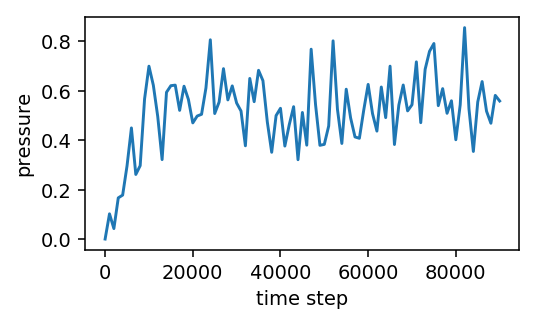

In [16]:
data = numpy.genfromtxt(fname = log_file, skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,10]);
pyplot.xlabel('time step');
pyplot.ylabel('pressure');

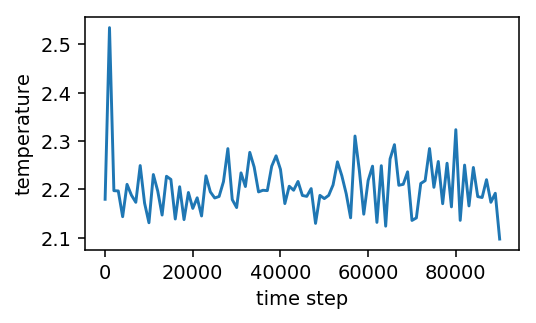

In [17]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,9]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');

# Configuration of the simulation box

In [ ]:
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,11]);
pyplot.xlabel('time step');
pyplot.ylabel('volume');

## System initial density

In [ ]:
particles = snapshot.particles.N

lx = snapshot.box.Lx
ly = snapshot.box.Ly
lz = snapshot.box.Lz
volume = lx * ly *lz

rho = particles / volume

print("Density = ", rho)